# VAE for COP Ising

In [31]:
import warnings
warnings.filterwarnings('ignore')
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm
from scipy.interpolate import interp1d

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model, load_model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import cluster

import pickle
import glob
import pandas
import argparse

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [32]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Analysis function

In [33]:
def predict(validation,loss,val_loss,center=[0,0],rang=1):
    nmr=args.reconstruction
    x_test_encodedMu = encoder.predict(validation, batch_size=batch_size)
    
    f=plt.figure(figsize=(12, 12))

    # Latent space mapping
    ax=plt.subplot2grid((3, 2), (0, 0))
    ax.scatter( x_test_encodedMu[:nmr,0],x_test_encodedMu[:nmr,1],s=1,c=validationlabels[:nmr,1])
    ax.set_ylabel("Latent 1")
    ax.set_xlabel("Latent 2")

    # Latents vs. T
    ax=plt.subplot2grid((3, 2), (1, 0))
    ax.scatter( validationlabels[:nmr,1],np.sqrt(x_test_encodedMu[:nmr,0]**2+x_test_encodedMu[:nmr,1]**2),c=validationlabels[:nmr,0])
    ax.set_xlabel("T")
    ax.set_ylabel("Norm of latent parameter")

    # Latents vs. OP
    ax=plt.subplot2grid((3, 2), (2, 0))
    ax.scatter( validationlabels[:nmr,0],np.sqrt(x_test_encodedMu[:nmr,0]**2+x_test_encodedMu[:nmr,1]**2),c=validationlabels[:nmr,1])
    ax.set_xlabel("S")
    ax.set_ylabel("Norm of latent parameter")

    if loss != None:
        # Training evoluion
        ax=plt.subplot2grid((3, 2), (0, 1))
        ax.plot(loss,'.-',label='Training');
        ax.plot(val_loss,'.-',label='Validation');
        ax.legend()
        ax.set_xlabel("Epoch")

    # Prediction
    ax=plt.subplot2grid((3, 2), (1, 1),rowspan=2)
    n = 11  
    digit_size = 40
    figure = np.zeros((digit_size * n, digit_size*n))
    grid_x = rang*np.linspace(-1, 1, n)-center[0]
    grid_y = rang*np.linspace(-1, 1, n)-center[1]
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[yi,xi]]) * epsilon_std
            x_decoded = generator.predict(z_sample)
            digit=x_decoded[0].reshape(digit_size, digit_size)
            digit = np.floor(0.5+digit)
            figure[i * digit_size: (i + 1) * digit_size ,
                   j * digit_size: (j + 1) * digit_size] = digit

    spacing = 40 
    minorLocator = MultipleLocator(spacing)
    ax.imshow(figure.T,cmap=plt.get_cmap('binary'))
    ax.yaxis.set_minor_locator(minorLocator)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.grid(which = 'minor')

    plt.tight_layout()
    
    return x_test_encodedMu



## Load data

In [34]:
generator=load_model("generator.h5")
encoder=load_model("encoderMu.h5")

In [35]:
args=load_obj("args")
args.dir="."
batch_size=args.batch
epsilon_std=args.epsilon

In [36]:
# Reading the training files to memory
samples=args.temprep*args.temps*args.samples
alldata=np.zeros((samples,args.size+args.labels),dtype=float)
filelist=sorted(glob.glob(args.dir+"/*gz"))
print("Loading %s files."%len(filelist))
for i,file in enumerate(filelist[:]):
    data=pandas.read_table(file,sep=" ",skiprows=[0],nrows=args.samples)
    alldata[i*args.samples:i*args.samples+args.samples]=data.values[:,:(args.size+args.labels)]

Loading 72 files.


In [37]:
np.random.shuffle( alldata )
trainingfrac=5/6;
tn=int(trainingfrac*samples);
training = alldata[:tn,:args.size]#.reshape((tn,int(np.sqrt(args.size)),int(np.sqrt(args.size)),1))
validation= alldata[tn:,:args.size]#.reshape((samples-tn,int(np.sqrt(args.size)),int(np.sqrt(args.size)),1))

traininglabels = alldata[:tn,args.size:]
validationlabels= alldata[tn:,args.size:]
training = (training+1).astype('float32') / 2.    # Rescale for cross-entropy
validation = (validation+1).astype('float32') / 2.# Rescale for cross-entropy

## Do prediction

### Full view

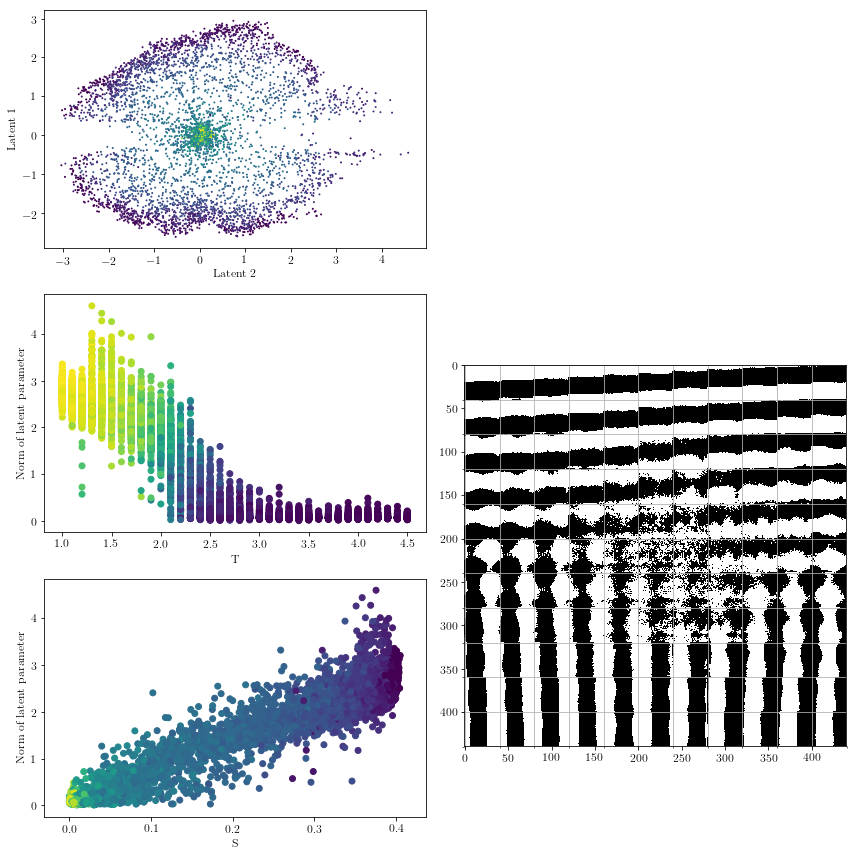

In [38]:
res=predict(validation,None,None,[0,0],1)

## Clustering the latents

In [10]:
spectral = cluster.SpectralClustering(
        n_clusters=2, eigen_solver='arpack',
        affinity="rbf")

In [11]:
spectral.fit(res[:5000])
y_pred = spectral.labels_.astype(np.int)

### Setup Plotting

In [41]:
# Single column PRL Figure
fig_width=3.404
# Double column
fig_width_d=7.085
params = {'backend': 'agg',
          'axes.labelsize': 24,
          'legend.fontsize': 36,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'font.family':'serif',
          'font.serif':['Computer Modern Roman'],
          'font.size':'24',
          'text.usetex': True}
matplotlib.rcParams.update(params)

### Plot the cluster

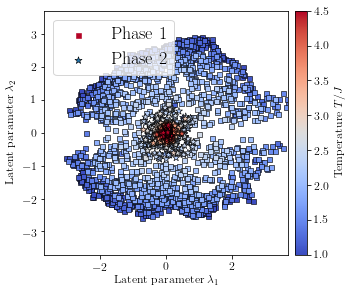

In [13]:
f=plt.figure(figsize=(0.75*fig_width_d,0.75*fig_width_d*0.8))
ax=f.add_subplot(111)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
lala=np.argsort(validationlabels[:5000,1])
im=ax.scatter(res[:5000,0][lala][y_pred[lala]==0],res[:5000,1][lala][y_pred[lala]==0],
            edgecolor='k',linewidth=.6,s=25,marker='s',label='Phase 1',
            c=validationlabels[:5000,1][lala][y_pred[lala]==0],cmap=plt.get_cmap('coolwarm'),vmin=1,vmax=4.5)
im=ax.scatter(res[:5000,0][lala][y_pred[lala]==1],res[:5000,1][lala][y_pred[lala]==1],
            edgecolor='k',linewidth=.6,s=55,marker='*',label='Phase 2',
            c=validationlabels[:5000,1][lala][y_pred[lala]==1],cmap=plt.get_cmap('coolwarm'),vmin=1,vmax=4.5)
leg=ax.legend()
leg.legendHandles[0].set_color(plt.get_cmap('coolwarm')(4.5))
cbar=f.colorbar(im,cax)
cbar.ax.set_ylabel('Temperature $T/J$')
ax.set_aspect('equal', 'datalim')
ax.set_xlim(-3.7,3.7);
ax.set_ylim(-3.7,3.7);
ax.set_xlabel("Latent parameter $\lambda_1$")
ax.set_ylabel("Latent parameter $\lambda_2$")

plt.tight_layout()


plt.savefig("clustering.pdf")

### OP vs. latents

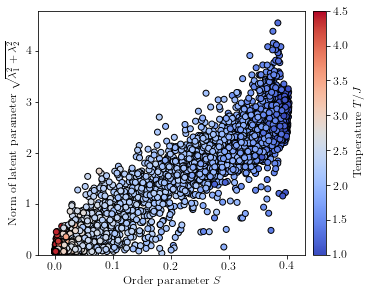

In [17]:
f=plt.figure(figsize=(0.75*fig_width_d,0.75*fig_width_d*0.8))
ax=f.add_subplot(111)


nmr=10000
# Latents vs. OP
ax=f.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
im=ax.scatter( validationlabels[:nmr,0],np.sqrt(res[:nmr,0]**2+res[:nmr,1]**2),c=validationlabels[:nmr,1],
              cmap=plt.get_cmap('coolwarm'),edgecolor='k',linewidth=1)
ax.set_xlabel("Order parameter $S$")
cbar=f.colorbar(im,cax)
cbar.ax.set_ylabel("Temperature $T/J$")
ax.set_ylabel("Norm of latent parameter $\sqrt{\lambda_1^2+\lambda_2^2}$")
ax.set_ylim(0,)


plt.tight_layout()
plt.savefig("op.pdf")

### T vs latents

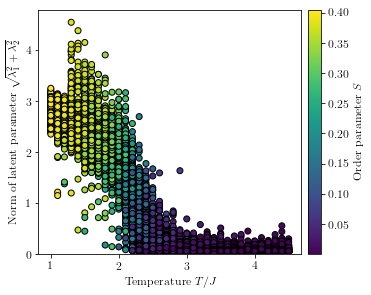

In [18]:
f=plt.figure(figsize=(0.75*fig_width_d,0.75*fig_width_d*0.8))
ax=f.add_subplot(111)


nmr=10000
# Latents vs. OP
ax=f.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
im=ax.scatter( validationlabels[:nmr,1],np.sqrt(res[:nmr,0]**2+res[:nmr,1]**2),c=validationlabels[:nmr,0],
              cmap=plt.get_cmap('viridis'),edgecolor='k',linewidth=1)
ax.set_xlabel("Temperature $T/J$")
cbar=f.colorbar(im,cax)
cbar.ax.set_ylabel("Order parameter $S$")
ax.set_ylabel("Norm of latent parameter $\sqrt{\lambda_1^2+\lambda_2^2}$")
ax.set_ylim(0,)

plt.tight_layout()
plt.savefig("temp.pdf")

### T vs op

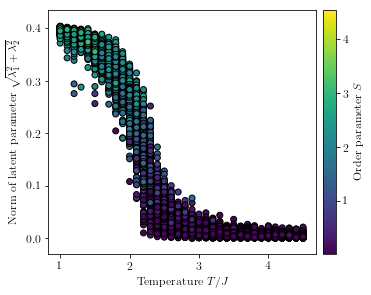

In [19]:
f=plt.figure(figsize=(0.75*fig_width_d,0.75*fig_width_d*0.8))
ax=f.add_subplot(111)


nmr=10000

ax=f.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
im=ax.scatter( validationlabels[:nmr,1],validationlabels[:nmr,0],c=np.sqrt(res[:nmr,0]**2+res[:nmr,1]**2),
              cmap=plt.get_cmap('viridis'),edgecolor='k',linewidth=1)
ax.set_xlabel("Temperature $T/J$")
cbar=f.colorbar(im,cax)
cbar.ax.set_ylabel("Order parameter $S$")
ax.set_ylabel("Norm of latent parameter $\sqrt{\lambda_1^2+\lambda_2^2}$")

plt.tight_layout()
plt.savefig("measured.pdf")

### Generated

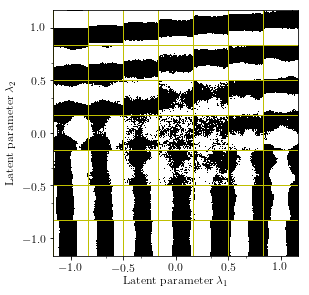

In [20]:
f=plt.figure(figsize=(0.75*fig_width_d,0.75*fig_width_d*0.8))
ax=f.add_subplot(111)
rang=1
center=[0,0]
n = 7
digit_size = 40
figure = np.zeros((digit_size * n, digit_size*n))
grid_x = rang*np.linspace(-1, 1, n)-center[0]
grid_y = rang*np.linspace(-1, 1, n)-center[1]
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[yi,xi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit=x_decoded[0].reshape(digit_size, digit_size)
        digit = np.floor(0.5+digit)
        figure[i * digit_size: (i + 1) * digit_size ,
               j * digit_size: (j + 1) * digit_size] = digit

spacing = np.diff(grid_x)[0]
minorLocator = MultipleLocator(spacing)
ax.imshow(figure.T,cmap=plt.get_cmap('binary'),extent=[grid_x[0]-np.diff(grid_x)[0]/2,grid_x[-1]+np.diff(grid_x)[0]/2]*2)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.set_xlabel("Latent parameter $\lambda_1$")
ax.set_ylabel("Latent parameter $\lambda_2$")
#plt.grid(which = 'minor')
for i in xrange(n):
    ax.axhline(grid_x[0]-np.diff(grid_x)[0]/2+i*spacing,zorder=1,color='y',lw=1)
    ax.axvline(grid_x[0]-np.diff(grid_x)[0]/2+i*spacing,zorder=1,color='y',lw=1)

plt.tight_layout()
plt.savefig("predict.pdf")

## Predict the phase transition

### Do many clusters 

In [19]:
temps=np.unique(alldata[:,-1])

In [20]:
labelsperT={}
for temp in np.unique(alldata[:,-1]):
    labelsperT[temp]=[]

iterations=20
for i in xrange(iterations):
    np.random.shuffle( alldata )
    validation= alldata[:5000,:args.size]
    temperature= alldata[:5000,-1]
    latent = encoder.predict((validation+1).astype('float32')/2., batch_size=batch_size)
    spectral = cluster.SpectralClustering(
            n_clusters=2, eigen_solver='arpack',
            affinity="rbf")
    
    spectral.fit(latent)
    pred = spectral.labels_.astype(np.int)
    if pred[np.argmin(np.sqrt(latent[:,1]**2+latent[:,0]**2))]==1:
        pred = np.mod(pred+1,2)
    
    for j in xrange(5000):
        labelsperT[temperature[j]].append(pred[j])

### Get the cluster labelling statistics

In [21]:
means=[]
standards=[]
for key in sorted(labelsperT.keys()):
    means.append(np.mean(labelsperT[key]))
    standards.append(np.std(labelsperT[key]))
inter=interp1d(temps,means)
tc=np.linspace(1,4.5,400)[np.argmin(abs(inter(np.linspace(1,4.5,400))-0.5))]
print "Tc=%.2f"%tc

Tc=2.28


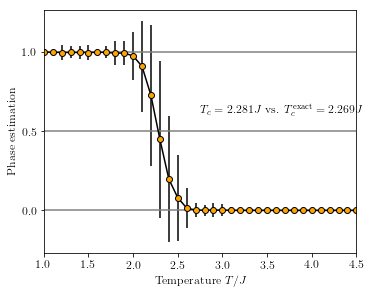

In [22]:
f=plt.figure(figsize=(0.75*fig_width_d,0.75*fig_width_d*0.8))
plt.errorbar(temps,means,yerr=standards,fmt='o-',mfc='orange',c='k')
plt.axhline(1,c='gray')
plt.axhline(0,c='gray')
plt.axhline(0.5,c='gray')
plt.yticks([0,0.5,1]);
plt.xlim(temps[0],temps[-1])
plt.xlabel("Temperature $T/J$")
plt.ylabel("Phase estimation")
plt.text(2.75,0.6,"$T_c=%.3fJ$ vs. $T_c^{\\rm exact}=%.3fJ$"%(tc,2./np.log(1+np.sqrt(2))))
plt.tight_layout()

plt.savefig("phaseEstimation.pdf")

## Plot for the Blog

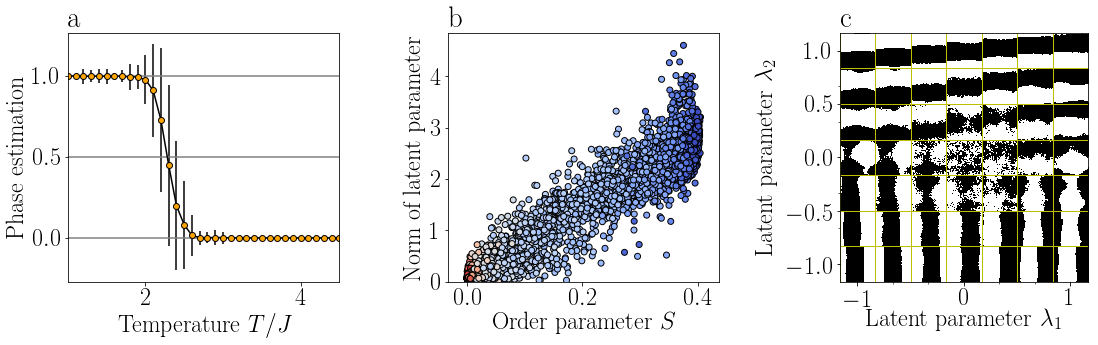

In [50]:
f=plt.figure(figsize=(3*0.75*fig_width_d,0.75*fig_width_d))
ax=f.add_subplot(131)
ax.errorbar(temps,means,yerr=standards,fmt='o-',mfc='orange',c='k')
ax.set_title("a",loc='left')
ax.axhline(1,c='gray')
ax.axhline(0,c='gray')
ax.axhline(0.5,c='gray')
ax.set_yticks([0,0.5,1]);
ax.set_xlim(temps[0],temps[-1])
ax.set_xlabel("Temperature $T/J$")
ax.set_ylabel("Phase estimation")
#plt.text(2.75,0.6,"$T_c=%.3fJ$ vs. $T_c^{\\rm exact}=%.3fJ$"%(tc,2./np.log(1+np.sqrt(2))))
#

nmr=10000


ax=f.add_subplot(132)
ax.set_title("b",loc='left')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
im=ax.scatter( validationlabels[:nmr,0],np.sqrt(res[:nmr,0]**2+res[:nmr,1]**2),c=validationlabels[:nmr,1],
              cmap=plt.get_cmap('coolwarm'),edgecolor='k',linewidth=1)
ax.set_xlabel("Order parameter $S$")
# cbar=f.colorbar(im,cax)
# cbar.ax.set_ylabel("Temperature $T/J$")
ax.set_ylabel("Norm of latent parameter")
ax.set_ylim(0,)

ax=f.add_subplot(133)
ax.set_title("c",loc='left')
rang=1
center=[0,0]
n = 7
digit_size = 40
figure = np.zeros((digit_size * n, digit_size*n))
grid_x = rang*np.linspace(-1, 1, n)-center[0]
grid_y = rang*np.linspace(-1, 1, n)-center[1]
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[yi,xi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit=x_decoded[0].reshape(digit_size, digit_size)
        digit = np.floor(0.5+digit)
        figure[i * digit_size: (i + 1) * digit_size ,
               j * digit_size: (j + 1) * digit_size] = digit

spacing = np.diff(grid_x)[0]
minorLocator = MultipleLocator(spacing)
ax.imshow(figure.T,cmap=plt.get_cmap('binary'),extent=[grid_x[0]-np.diff(grid_x)[0]/2,grid_x[-1]+np.diff(grid_x)[0]/2]*2)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.set_xlabel("Latent parameter $\lambda_1$")
ax.set_ylabel("Latent parameter $\lambda_2$")
#plt.grid(which = 'minor')
for i in xrange(n):
    ax.axhline(grid_x[0]-np.diff(grid_x)[0]/2+i*spacing,zorder=1,color='y',lw=1)
    ax.axvline(grid_x[0]-np.diff(grid_x)[0]/2+i*spacing,zorder=1,color='y',lw=1)

plt.tight_layout()

plt.savefig("results.png",dpi=300)